# Milestone Project 2: Skimlit

Skimlit is a deep learning model that makes Medical Abstracts from papers from PubMed easier to read.

The paper we are replicating as well as the datasets are available at this link:
https://arxiv.org/pdf/1710.06071.pdf

The model architecture refereced in the above paper can be found here: https://arxiv.org/pdf/1612.05251.pdf

In [ ]:
# Confirm that we have access to a GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-def55fde-e7e0-bb99-c4f6-235c82e4df47)


# Get Data

We can get the dataset from the giuthub page of the authors of papers referenced above.

https://github.com/Franck-Dernoncourt/pubmed-rct

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


The authors have kindly split the data into a smaller dataset with 10% training data for us to conduct our experiments on.

In [ ]:
# Check what files are inside the /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign directory
!ls /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/
!ls /content/pubmed-rct/PubMed_20k_RCT

dev.txt  test.txt  train.txt
dev.txt  test.txt  train.txt


FYI: dev is a synonym for validation dataset

For our experiments, we will use the 20k datast with numbers replaced by '@' sign.

In [ ]:
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [ ]:
# Check all the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

# Visualizing the Data

In [ ]:
# Create a function to read the lines of a document
def get_lines(filename):
  '''
  Reads filename (a text file) and returns the lines of a text as a list.

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename.
  '''

  with open(filename, 'r') as f:
    return f.readlines()

In [ ]:
# Read in the train lines
train_lines = get_lines(data_dir + 'train.txt')
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

We can see that each abstract starts with '###' and ends with a new line, '\n'.

Each line starts with the label, followed by a tab, '\t'.

In [ ]:
len(train_lines)

210040

# Preprocessing Our Data

We will create a list of dictionaires to store our data.

In [ ]:
def preprocess_text_with_line_numbers(filename):
  '''
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents, and sorts through each line, extracting information like
  the label, the text, how many sentences are in the abstract and what sentence number the target line is.
  '''
  input_lines = get_lines(filename) # Get all lines from filename
  abstract_lines = '' # Create an empty abstract
  abstract_samples = [] # Create an empty list of abstracts

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith('###'):
      abstract_id = line
      abstract_lines = '' # Resets the abstract string
    
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines() # Split abstract into seperate lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data={} # Create an empty dictionary for each line
        target_text_split = abstract_line.split('\t') # Split target text from the target label
        line_data['target'] = target_text_split[0] # Get target label
        line_data['text'] = target_text_split[1].lower() # Get target text and set to lower case
        line_data['line_number'] = abstract_line_number
        line_data['total_lines'] = len(abstract_line_split) - 1 # How many lines in the abstract (start from 0)
        abstract_samples.append(line_data)

    else: # If above conditions are not fufiled, the line is a lebelled sentence
      abstract_lines += line

  return abstract_samples


In [ ]:
# Get the data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + 'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir + 'dev.txt')
test_samples = preprocess_text_with_line_numbers(data_dir + 'test.txt')
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 505 ms, sys: 68.5 ms, total: 573 ms
Wall time: 574 ms


In [ ]:
# Check the first abstract of our training data
train_samples[:14]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

Now that our data is in the format of a list of dictionaries, lets turn it into a pandas DataFrame

In [ ]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [ ]:
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
# Check the distribution of labels
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

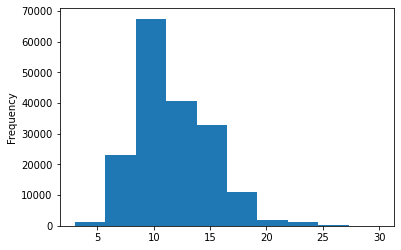

In [ ]:
# Check the length of different lines
train_df.total_lines.plot.hist();

## Get list of sentences

In [ ]:
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

In [ ]:
# View the first 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Turning target labels into numbers

We can either label encode or use One Hot Encoding.

## One Hot Encoded Labels

In [ ]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1, 1))

In [ ]:
train_labels_one_hot[:5]

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

## Label Encoded Labels

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

In [ ]:
train_labels_encoded[:5]

array([3, 2, 2, 2, 2])

In [ ]:
# Get Class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Model Experiments

We will start a series of modelling experiments.

Before using Deep learning methods, we will build a baseline model using a TF-IDF Multinomial Naive Bayes Model.

## model_0: Getting a baseline

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a Pipeline
model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Fit the pipeline
model_0.fit(train_sentences,
            train_labels_encoded)

Pipeline(memory=None,
         steps=[('tf-idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:
# Evaluate baseline model on validation dataset
model_0.score(val_sentences, val_labels_encoded)

0.7218323844829869

In [ ]:
# Make predictions using model_0
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-07-26 04:34:29--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-07-26 04:34:29 (87.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

# Calculate baseline results
baseline_results = calculate_results(val_labels_encoded, baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

Now that we have a baseline, we will attempt to beat this baseline using Deep learning Methods

Before that, we will have to prep our data, tokenize our text and then create an embedding.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

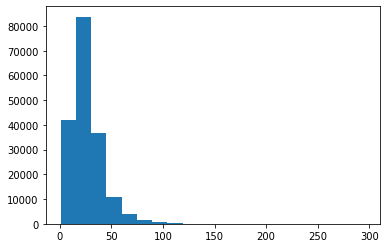

In [ ]:
# What is the distibution of sentence lengths?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

The vast majority of our sentence lengths are around 25 words long.

In [ ]:
# What is the sentence length at the 95 percentile?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

95% of training sentences have 55 words or less.

# Creating a Text Vectorization layer

Since we are attempting to replicate the the PubMed-RCT paper, we will use the same vocab size they used.

* 68000 for the 20k samples dataset
* 331000 for the 200k samples dataset

In [ ]:
max_tokens = 68000

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # Number of words in vocabulary
                                    output_sequence_length=output_seq_len) # Desired length of vectorized sequences

In [ ]:
# Adapt Text Vectorizer to training data
text_vectorizer.adapt(train_sentences)

In [ ]:
# Test text_vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f'Target Sentence:\n{target_sentence}\n')
print(f'Length of Text:\n{len(target_sentence.split())}\n')
print(f'Vectorized Text:\n{text_vectorizer([target_sentence])}')


Target Sentence:
pasi scores were assessed post hoc for improvement , by body region and component .

Length of Text:
15

Vectorized Text:
[[3235  119    9  113  624 1571   11  194   22  239 1575    3 1225    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [ ]:
# How many words are in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f'Number of words in vocabulary: {len(rct_20k_text_vocab)}')
print(f'Most common words: {rct_20k_text_vocab[:5]}')
print(f'Least common words: {rct_20k_text_vocab[-5:]}')

Number of words in vocabulary: 64841
Most common words: ['', '[UNK]', 'the', 'and', 'of']
Least common words: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


Note that the number of words in our vocabulary is < 68 000. this means that our text vectorizer covers every word in the training vocabulary.

In [ ]:
# get the config of text_vectorizer
text_vectorizer.get_config()

{'dtype': 'string',
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary_size': 64841}

# Creating a Token Embedding Layer

In [ ]:
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # Number of words in our vocabulary
                               output_dim=128, # different numbers result in different number of trainable parameters
                               mask_zero=True, # Use masking to handle variable sequence length
                               name='token_embedding')

In [ ]:
# Show sample embedding
print(f'Sentence before Vectorization:\n{target_sentence}\n')
vectorized_sentence = text_vectorizer([target_sentence])
print(f'Sentence after Vetorization:\n{vectorized_sentence}\n')
embedded_sentence = token_embed(vectorized_sentence)
print(f'Sentence after embedding:\n{embedded_sentence}\n')
print(f'Embedded Sentence Shape: {embedded_sentence.shape}')

Sentence before Vectorization:
pasi scores were assessed post hoc for improvement , by body region and component .

Sentence after Vetorization:
[[3235  119    9  113  624 1571   11  194   22  239 1575    3 1225    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
[[[-0.00632683 -0.0182449   0.04677414 ... -0.02948796 -0.01765001
   -0.03773016]
  [ 0.02480442  0.02645219 -0.02757239 ... -0.03329334 -0.01781879
    0.0342514 ]
  [-0.03594398  0.00593088 -0.01864072 ... -0.00921731  0.0113775
   -0.02239311]
  ...
  [-0.02659891 -0.00458388 -0.03464477 ... -0.01123131  0.02858735
   -0.04474845]
  [-0.02659891 -0.00458388 -0.03464477 ... -0.01123131  0.02858735
   -0.04474845]
  [-0.02659891 -0.00458388 -0.03464477 ... -0.01123131  0.02858735
   -0.04474845]]]

Embedded Sentence Shape: (1, 55, 128)

# Creating Datasets

Making sure our data runs as fast as possible using the tf.data API.

In [ ]:
# Turn our data into tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

## Turning our data into prefetched datasets

In [ ]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # We will not shuffle the data as the order is important
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

# Building model_1: Conv1D layer

In [ ]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 55)                0         
_________________________________________________________________
token_embedding (Embedding)  (None, 55, 128)           8299648   
_________________________________________________________________
conv1d (Conv1D)              (None, 55, 64)            41024     
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 8,340,997
Trainable params: 8,340,997
Non-trainable params: 0
___________________________________________________

Even though we are using only 10% of the data, fitting the models will still take a significant amount of time.

Therefore, we will further reduce the amount of training samples when fitting.

In [ ]:
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch = int(0.1 * len(train_dataset)), # We will only train on 10% of train_datasets
                              epochs=3,
                              validation_data=val_dataset,
                              validation_steps= int(0.1 * len(val_dataset))) # Only validate on 10% of val_datasets

Epoch 1/3
562/562 [==============================] - 77s 81ms/step - loss: 0.9132 - accuracy: 0.6393 - val_loss: 0.6852 - val_accuracy: 0.7380
Epoch 2/3
562/562 [==============================] - 46s 81ms/step - loss: 0.6589 - accuracy: 0.7523 - val_loss: 0.6290 - val_accuracy: 0.7689
Epoch 3/3
562/562 [==============================] - 45s 80ms/step - loss: 0.6207 - accuracy: 0.7738 - val_loss: 0.6001 - val_accuracy: 0.7846


In [ ]:
# Evaluate on the whole dataset
model_1.evaluate(val_dataset)

945/945 [==============================] - 3s 4ms/step - loss: 0.6023 - accuracy: 0.7844


[0.6023184061050415, 0.7844234108924866]

In [ ]:
# Make and Visualize model predictions
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[3.9755169e-01, 1.8731204e-01, 1.0834618e-01, 2.7419481e-01,
         3.2595243e-02],
        [4.8155981e-01, 2.3131916e-01, 1.3045231e-02, 2.6747438e-01,
         6.6013434e-03],
        [1.6477941e-01, 1.2612923e-02, 1.4049038e-03, 8.2115787e-01,
         4.4909990e-05],
        ...,
        [2.9322837e-06, 6.7615858e-04, 5.1524892e-04, 2.8926406e-06,
         9.9880278e-01],
        [6.7988813e-02, 4.0886277e-01, 1.3211198e-01, 8.3059460e-02,
         3.0797699e-01],
        [1.4375943e-01, 7.2342539e-01, 3.0929336e-02, 3.1301908e-02,
         7.0583895e-02]], dtype=float32), (30212, 5))

In [ ]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
# Calculate model_1 results
model_1_results = calculate_results(val_labels_encoded, model_1_preds)
model_1_results

{'accuracy': 78.44234079173839,
 'f1': 0.7819273587875898,
 'precision': 0.7812097945881484,
 'recall': 0.7844234079173839}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

Model_1 has managed to beat our baseline model.

# Building model_2:Feature Extraction with pretrained Token Embeddings

Now we will use pretrained word embeddings from TensorFlow Hub.

We will use the Universal Sentence Encoder (USE): https://tfhub.dev/google/universal-sentence-encoder/4

In [ ]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        trainable=False,
                                        name='universal_sentence_encoder')

In [ ]:
# Test our pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f'Random sentence:\n{random_train_sentence}\n')
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence]) # We do not need to tokenize our text
print(f'Sentence after embedding:\n{use_embedded_sentence[0][:30]}\n')
print(f'Length of sentence embedding:{len(use_embedded_sentence[0])}')

Random sentence:
parasacral transcutaneous electrical stimulation was as effective as oxybutynin to treat overactive bladder in children .

Sentence after embedding:
[-0.02729528  0.07856449 -0.01614238 -0.0462852  -0.08789189  0.07064888
 -0.08235468 -0.07264095  0.01910429  0.06059899  0.08250552  0.06973483
  0.03858436  0.04158418  0.0005404  -0.0258651  -0.09205925  0.06968832
 -0.0325104   0.04372172 -0.07853761 -0.06693521 -0.03926121 -0.07471775
  0.01640867  0.05373787 -0.01700107 -0.00231356  0.03435077  0.06861265]

Length of sentence embedding:512


In [ ]:
# Building model_2
inputs = layers.Input(shape=[], dtype=tf.string) 
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation='relu')(pretrained_embedding)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_2 = tf.keras.Model(inputs, outputs, name='model_2_USE_feature_extractor')

model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
universal_sentence_encoder ( (None, 512)               256797824 
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Fit model_2
history_model_2 = model_2.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=val_dataset,
                              validation_steps=int(0.1*len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 9s 12ms/step - loss: 0.9156 - accuracy: 0.6518 - val_loss: 0.7961 - val_accuracy: 0.6892
Epoch 2/3
562/562 [==============================] - 6s 11ms/step - loss: 0.7682 - accuracy: 0.7021 - val_loss: 0.7538 - val_accuracy: 0.7048
Epoch 3/3
562/562 [==============================] - 6s 12ms/step - loss: 0.7508 - accuracy: 0.7136 - val_loss: 0.7375 - val_accuracy: 0.7134


In [ ]:
# Evaluate model_2
model_2.evaluate(val_dataset)

945/945 [==============================] - 9s 10ms/step - loss: 0.7398 - accuracy: 0.7146


[0.7397724986076355, 0.7145836353302002]

In [ ]:
model_2_pred_probs = model_2.predict(val_dataset)
model_2_pred_probs

array([[4.2411238e-01, 3.8394669e-01, 2.5074563e-03, 1.8190694e-01,
        7.5265565e-03],
       [3.4189075e-01, 5.0628382e-01, 4.2953901e-03, 1.4487694e-01,
        2.6530828e-03],
       [2.4130009e-01, 1.4541566e-01, 1.6368713e-02, 5.5143452e-01,
        4.5481030e-02],
       ...,
       [2.0298744e-03, 5.1021040e-03, 4.6517007e-02, 9.3518809e-04,
        9.4541585e-01],
       [4.2782407e-03, 4.7598690e-02, 1.8089204e-01, 1.3907009e-03,
        7.6584029e-01],
       [1.8610096e-01, 2.4416770e-01, 5.0855625e-01, 8.7364353e-03,
        5.2438639e-02]], dtype=float32)

In [ ]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
model_2_results = calculate_results(val_labels_encoded, model_2_preds)
model_2_results

{'accuracy': 71.45836091619225,
 'f1': 0.7114065751576728,
 'precision': 0.7148748960300813,
 'recall': 0.7145836091619224}

# Building model_3: Conv1D with char level embeddings

The Model we are replicating states that they used a combination of token level embeddings as well as char level embeddings.

Currently we only have a text vectorization layer. We will need to create a char vectorization layer.

## Creating a character level Tokenization layer

In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

This is what our data looks like currently.

We will have to split each word into its characters.

In [ ]:
# Make function to split sentences into characters.
def split_chars(text):
  return ' '.join(list(text)) # We are essentially adding a space between each character

# Test our text splitting function
split_chars(random_train_sentence)

'p a r a s a c r a l   t r a n s c u t a n e o u s   e l e c t r i c a l   s t i m u l a t i o n   w a s   a s   e f f e c t i v e   a s   o x y b u t y n i n   t o   t r e a t   o v e r a c t i v e   b l a d d e r   i n   c h i l d r e n   .'

In [ ]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [ ]:
# What is the average character length
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_lens = np.mean(char_lens)
mean_char_lens

149.3662574983337

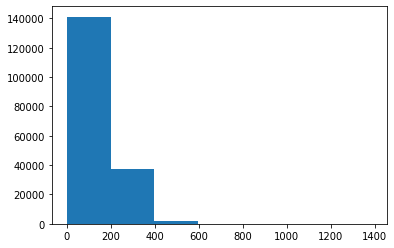

In [ ]:
# Check the distribution of our sequences at a character level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [ ]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char level token vectorizer 
NUM_CHAR_TOKENS = len(alphabet) + 2 # for space and OOV (Out of Vocab) token

char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    name='char_vectorizer')

In [ ]:
# Adapt char_vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [ ]:
char_vocab = char_vectorizer.get_vocabulary()
print(f'Number of different characters in character vocab: {len(char_vocab)}')
print(f'5 most common characters: {char_vocab[:5]}')
print(f'5 least common characters: {char_vocab[-5:]}')

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
# Test out char_vectorizer
random_train_char = random.choice(train_chars)
print(f'Charified Text:\n{random_train_char}\n')
print(f'Length of Charified Text: {len(random_train_char.split())}')
vectorized_char = char_vectorizer([random_train_char])
print(f'Vectorized char:\n{vectorized_char}\n')
print(f'Length of Vectorized Chars: {len(vectorized_char[0])}')

Charified Text:
t h e o r e t i c a l   c o n s t r u c t s   a c r o s s   t h e   t h r e e   t h e o r i e s   w e r e   t e s t e d   t o   p r o s p e c t i v e l y   p r e d i c t   p a   b e h a v i o u r   (   o b j e c t i v e   a n d   s e l f - r e p o r t   )   a c r o s s   t h r e e   @ - m o n t h   t i m e   i n t e r v a l s   (   b a s e l i n e - @   ,   @ - @   ,   @ - @   m o n t h s   )   u s i n g   s t r u c t u r a l   e q u a t i o n   m o d e l l i n g   .

Length of Charified Text: 201
Vectorized char:
[[ 3 13  2  7  8  2  3  4 11  5 12 11  7  6  9  3  8 16 11  3  9  5 11  8
   7  9  9  3 13  2  3 13  8  2  2  3 13  2  7  8  4  2  9 20  2  8  2  3
   2  9  3  2 10  3  7 14  8  7  9 14  2 11  3  4 21  2 12 19 14  8  2 10
   4 11  3 14  5 22  2 13  5 21  4  7 16  8  7 22 27  2 11  3  4 21  2  5
   6 10  9  2 12 17  8  2 14  7  8  3  5 11  8  7  9  9  3 13  8  2  2 15
   7  6  3 13  3  4 15  2  4  6  3  2  8 21  5 12  9 22  5  9  2 12  4  6
   2 15  7  6  3 13 

## Creating a character level Embedding layer

In [ ]:
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=25, # this is the size of the char_embeddings in the papers referenced
                              mask_zero=True,
                              name='char_embedding')

In [ ]:
# Test out character embedding layer
print(f'Charified Text:\n{random_train_char}\n')
char_embed_example = char_embed(char_vectorizer([random_train_char]))
print(f'Embedded Chars:\n{char_embed_example}\n')
print(f'Embedded Char Shape: {char_embed_example.shape}')

Charified Text:
t h e o r e t i c a l   c o n s t r u c t s   a c r o s s   t h e   t h r e e   t h e o r i e s   w e r e   t e s t e d   t o   p r o s p e c t i v e l y   p r e d i c t   p a   b e h a v i o u r   (   o b j e c t i v e   a n d   s e l f - r e p o r t   )   a c r o s s   t h r e e   @ - m o n t h   t i m e   i n t e r v a l s   (   b a s e l i n e - @   ,   @ - @   ,   @ - @   m o n t h s   )   u s i n g   s t r u c t u r a l   e q u a t i o n   m o d e l l i n g   .

Embedded Chars:
[[[ 0.03181588  0.03291846  0.00434625 ...  0.03201344  0.01255308
    0.02068484]
  [ 0.01013077 -0.04031458  0.02127781 ...  0.01748354 -0.00405773
    0.01893598]
  [-0.0055664  -0.03845844  0.03750305 ... -0.00844913 -0.00178965
   -0.03068583]
  ...
  [ 0.03496723 -0.04220156 -0.03138676 ...  0.0330204   0.03447591
    0.02242455]
  [ 0.03496723 -0.04220156 -0.03138676 ...  0.0330204   0.03447591
    0.02242455]
  [ 0.03496723 -0.04220156 -0.03138676 ...  0.0330204   0.03447591
    0.0

## Creating Char level prefetched datasets

In [ ]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

## Building Model_3

In [ ]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_3 = tf.keras.Model(inputs, outputs, name='model_3_conv1d_char_embeddings')

model_3.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
char_vectorizer (TextVectori (None, 290)               0         
_________________________________________________________________
char_embedding (Embedding)   (None, 290, 25)           700       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 290, 64)           8064      
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
__________________________________

In [ ]:
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 4s 7ms/step - loss: 1.2684 - accuracy: 0.4829 - val_loss: 1.0611 - val_accuracy: 0.5798
Epoch 2/3
562/562 [==============================] - 4s 6ms/step - loss: 1.0207 - accuracy: 0.5924 - val_loss: 0.9545 - val_accuracy: 0.6303
Epoch 3/3
562/562 [==============================] - 3s 6ms/step - loss: 0.9311 - accuracy: 0.6373 - val_loss: 0.8795 - val_accuracy: 0.6609


Evaluating Model_3

In [ ]:
# Make predictions
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)

# Calculate the results
model_3_results = calculate_results(val_labels_encoded, model_3_preds)
model_3_results

{'accuracy': 65.39123527075334,
 'f1': 0.6450344929939943,
 'precision': 0.6521477850823675,
 'recall': 0.6539123527075335}

# Model_4: Hybrid Embedding (Pretrained token embeddings + Character Embeddings)

Model_4 will be a combination of model_2 and model_3.

1. Create a token level embedding model (similar to model_1)
2. Create a character level embedding model (model_3 with a slight change)
3. Combine the above 2 with a concatenate layer (`layers.Concatenate()`).
4. Build a series of output layers on top of 3.
5. Construct a model which takes token and character level sequences as input and produces sequence label probabilitiesas output

## Set up token inputs/model

In [ ]:
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_input')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_output)

## Set up char inputs/model

In [ ]:
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

## Concatenate token and char inputs (creates hybrid token embedding)

In [ ]:
token_char_concat = layers.Concatenate(name='token_char_hybrid')([token_model.output, char_model.output])

## Create output layers

We will add in  dropouts to this layer. Dropouts prevent overfitting.

In [ ]:
combined_dropout = layers.Dropout(0.5)(token_char_concat) # 50% of the learned patterns are set to 0
combined_dense = layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation='softmax')(final_dropout)

## Create Model_4

In [ ]:
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input], #*
                         outputs=output_layer,
                         name='model_4_token_char_embeddings')

model_4.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
model_4.summary()

Model: "model_4_token_char_embeddings"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_input (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_input[0][0]                 
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_input[0][0]                
______________________________________________________________________

## Visualizing Model_4

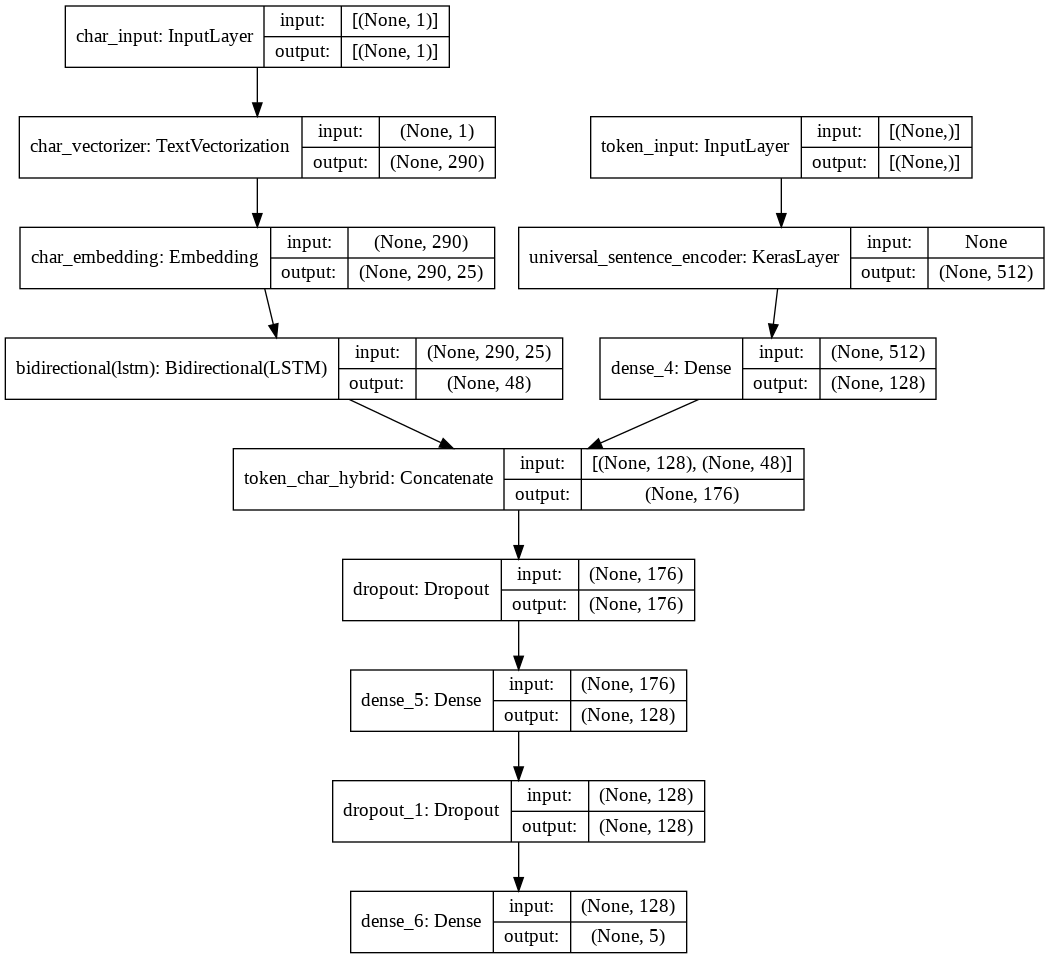

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True)

## Combining token and character data into a tf.data dataset

In [ ]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # The order must match the list in *
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # Make the labels

train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

# prefetch and batch our data set
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same for validation dataset
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # Make the data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # Make the labels

val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))

val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same for test dataset
test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars)) # Make the data
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot) # Make the labels

test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data, test_char_token_labels))

test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check our traing char and token dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>)

## Fitting model_4

In [ ]:
history_model_4 = model_4.fit(train_char_token_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 36s 51ms/step - loss: 0.9875 - accuracy: 0.6120 - val_loss: 0.7877 - val_accuracy: 0.6945
Epoch 2/3
562/562 [==============================] - 27s 48ms/step - loss: 0.8039 - accuracy: 0.6886 - val_loss: 0.7238 - val_accuracy: 0.7281
Epoch 3/3
562/562 [==============================] - 24s 42ms/step - loss: 0.7783 - accuracy: 0.7045 - val_loss: 0.6895 - val_accuracy: 0.7397


## Evaluating model_4

In [ ]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 21s 22ms/step - loss: 0.6940 - accuracy: 0.7341


[0.6939975619316101, 0.7340791821479797]

In [ ]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)

In [ ]:
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 2])>

In [ ]:
model_4_results = calculate_results(val_labels_encoded, model_4_preds)
model_4_results

{'accuracy': 73.407917383821,
 'f1': 0.7309241402797786,
 'precision': 0.7335313152259603,
 'recall': 0.73407917383821}

# Model_5: Pretrained Token Embeddings + Character Embeddings + Positional Embeddings

Abstracts typically come ina sequential order. We will create positional embeddings for model_5 take this into account

Recall what train_df looks like

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


## Create Positional Embeddings

In [ ]:
# How many different line numbers are there?
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

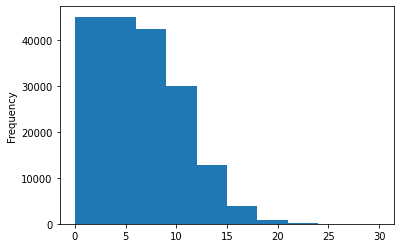

In [ ]:
# Check the distribution of line_number column
train_df['line_number'].plot.hist()

We will use one-hot-encoding to encode the line number, however, we will only do so for the first 15 line numbers to, orevent the feature vector from becoming too long,

### Encoding the 'line_number' column

In [ ]:
# Use Tensorflow to one-hot-encode the 'line_number' column
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
train_line_numbers_one_hot[:14], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(14, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

In [ ]:
# Do the same for our val_df and test_df
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)

### Encoding the 'total_lines' column

In [ ]:
train_df['total_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

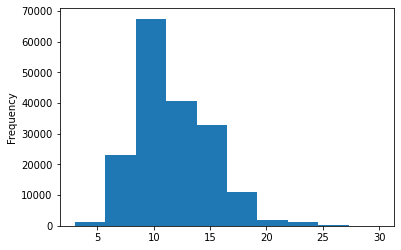

In [ ]:
train_df['total_lines'].plot.hist();

In [ ]:
# Check the coverage of 'total_lines' value of 20
np.percentile(train_df['total_lines'], 98)

20.0

In [ ]:
# Use Tensorflow to one-hot-encode the 'total_lines' column
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
train_total_lines_one_hot[:10], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

In [ ]:
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)

## Building Model_5

1. Create a token level model
2. Create a char level model
3. Create a model for the line_number feature
4. Create a model for the total_lines feature
5. Combine the outputs of 1. and 2. using `tf.keras.layers.Concatenate()`
6. Combine the outputs of 3., 4., and 5. using `tf.keras.layers.Concatenate()`
7. Create a output layer for 6.
8. Combine the inputs of 1., 2., 3., and 4., and the outputs of 7. into a `tf.keras.Model()`

### 1. Token inputs

In [ ]:
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_inputs')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

### Char inputs

In [ ]:
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

### line_number inputs

In [ ]:
train_line_numbers_one_hot[0].shape

TensorShape([15])

In [ ]:
train_line_numbers_one_hot[0].dtype

tf.float32

In [ ]:
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name='line_number_input')
x = layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, x)

### total_lines inputs

In [ ]:
train_total_lines_one_hot[0].shape

TensorShape([20])

In [ ]:
train_total_lines_one_hot[0].dtype

tf.float32

In [ ]:
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name='total_line_input')
y = layers.Dense(32, activation='relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs, y)

### Combine token and char embedding layers

In [ ]:
combined_embeddings = layers.Concatenate(name='char_token_hybrid_embedding')([token_model.output, char_model.output])
z = layers.Dense(256, activation='relu')(combined_embeddings)
z = layers.Dropout(0.5)(z)

### Combine token+char embeddings, line_number and total_lines

In [ ]:
char_token_positional_embeddings = layers.Concatenate(name='char_token_positional_embedding')([line_number_model.output,
                                                                                               total_lines_model.output,
                                                                                               z])

### Create output layer

In [ ]:
output_layer = layers.Dense(num_classes, activation='softmax', name='output_layer')(char_token_positional_embeddings)

### Combining all the layers

In [ ]:
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name='model_5_token_char_positional_embedding')

In [ ]:
model_5.summary()

Model: "model_5_token_char_positional_embedding"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_inputs (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_inputs[0][0]                
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_inputs[0][0]               
____________________________________________________________

## Visualizing model_5

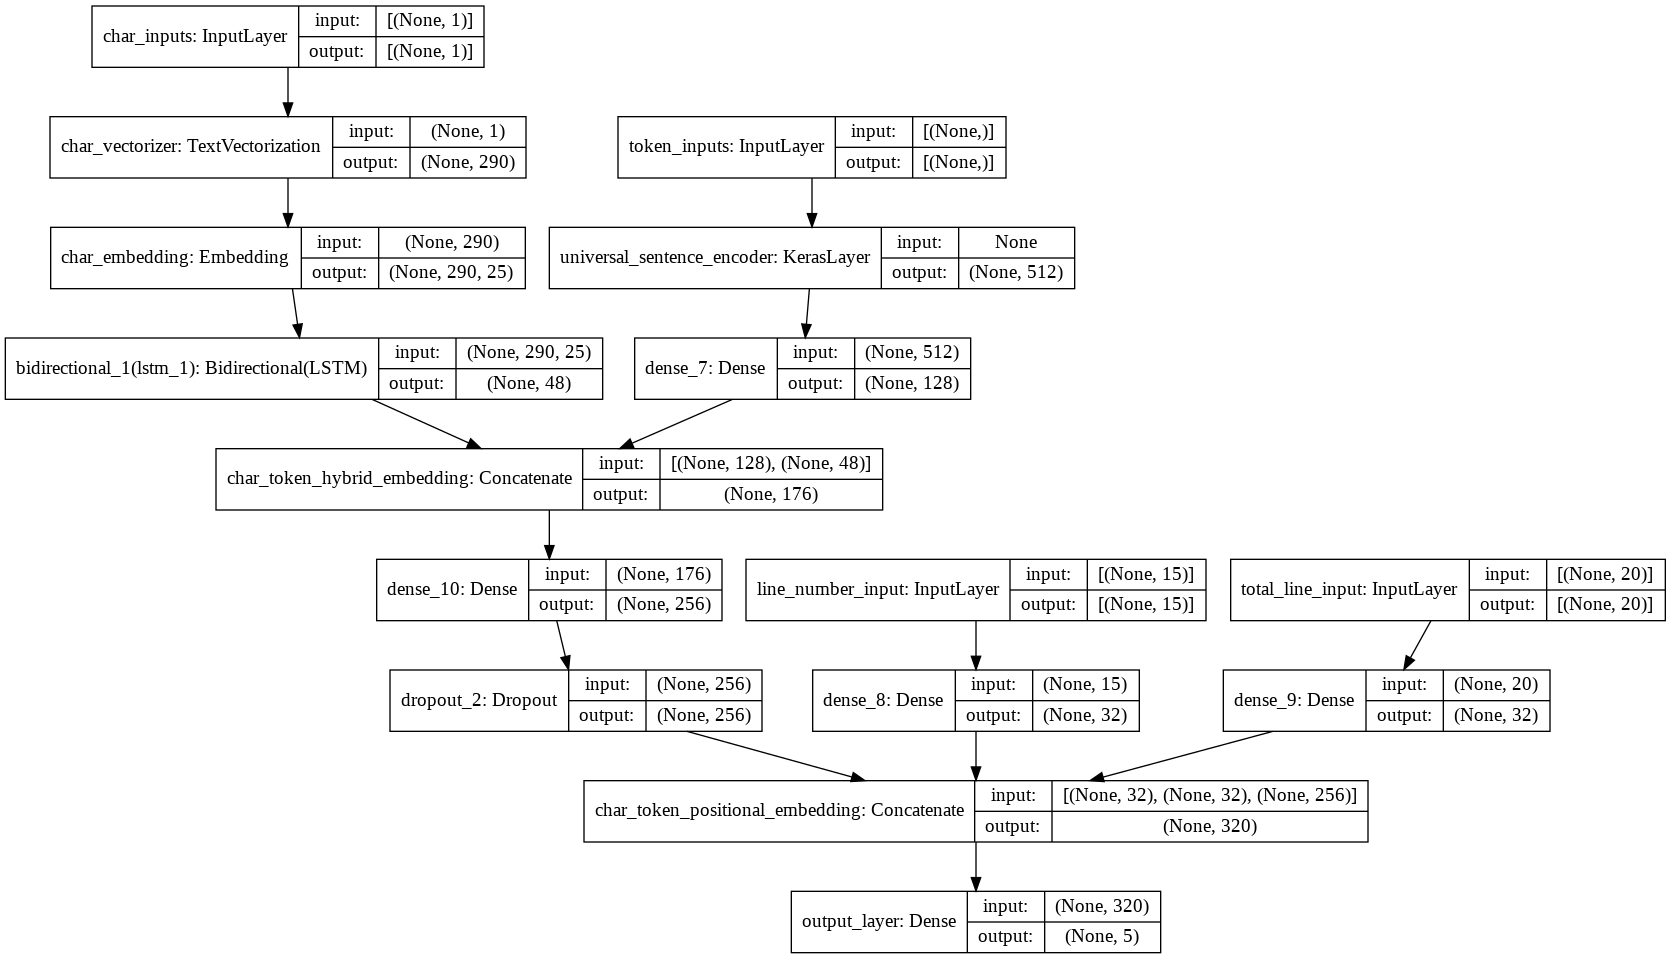

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes=True)

## Compiling model_5 with label smoothing

Label Smoothing: assigns some of the value from the class with the highest predicted probability to the other classes, hopefully increasing generalization.

Note: We need our labels to be one-hot-encoded to use label smoothing.

In [ ]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

## Creating Datasets for model_5

In [ ]:
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences, 
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data,train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences, 
                                                              val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data,val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
test_char_token_pos_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                              test_total_lines_one_hot,
                                                              test_sentences, 
                                                              test_chars))
test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_pos_dataset = tf.data.Dataset.zip((test_char_token_pos_data,test_char_token_pos_labels))
test_char_token_pos_dataset = test_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset, test_char_token_pos_dataset

(<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>)

## Fitting Model_5

In [ ]:
model_5.fit(train_char_token_pos_dataset,
            epochs=3,
            steps_per_epoch=int(0.1*len(train_char_token_pos_dataset)),
            validation_data=val_char_token_pos_dataset,
            validation_steps=int(0.1*len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 37s 53ms/step - loss: 1.0950 - accuracy: 0.7276 - val_loss: 0.9772 - val_accuracy: 0.8062
Epoch 2/3
562/562 [==============================] - 28s 51ms/step - loss: 0.9662 - accuracy: 0.8156 - val_loss: 0.9471 - val_accuracy: 0.8278
Epoch 3/3
562/562 [==============================] - 25s 45ms/step - loss: 0.9498 - accuracy: 0.8227 - val_loss: 0.9369 - val_accuracy: 0.8305


In [ ]:
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset)
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
model_5_results = calculate_results(val_labels_encoded, model_5_preds)
model_5_results

{'accuracy': 83.27154772937905,
 'f1': 0.8316198137680574,
 'precision': 0.8312978692929838,
 'recall': 0.8327154772937906}

Model_5 is our best performing model so far

# Comparing our model results

In [ ]:
all_model_results = pd.DataFrame({'model_0_baseline_results':baseline_results,
                                  'model_1_custom_token_embeddings': model_1_results,
                                  'model_2_pretrained_token_embedding': model_2_results,
                                  'model_3_custom_char_embedding': model_3_results,
                                  'model_4_char_token_embedding': model_4_results,
                                  'model_5_char_token_pos_embedding': model_5_results})
all_model_results = all_model_results.transpose()
# reduce accuracy to the same scale as the other metrics
all_model_results['accuracy'] = all_model_results['accuracy']/100
all_model_results

,accuracy,precision,recall,f1
model_0_baseline_results,0.721832,0.718647,0.721832,0.698925
model_1_custom_token_embeddings,0.784423,0.781210,0.784423,0.781927
model_2_pretrained_token_embedding,0.714584,0.714875,0.714584,0.711407
model_3_custom_char_embedding,0.653912,0.652148,0.653912,0.645034
model_4_char_token_embedding,0.734079,0.733531,0.734079,0.730924
model_5_char_token_pos_embedding,0.832715,0.831298,0.832715,0.831620


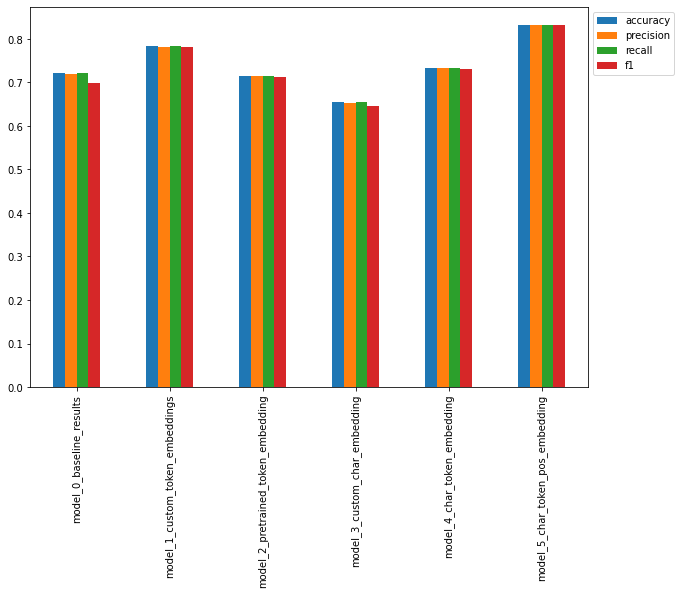

In [ ]:
# plot all model results
all_model_results.plot(kind='bar', figsize=(10,7)).legend(bbox_to_anchor=(1.0, 1.0));

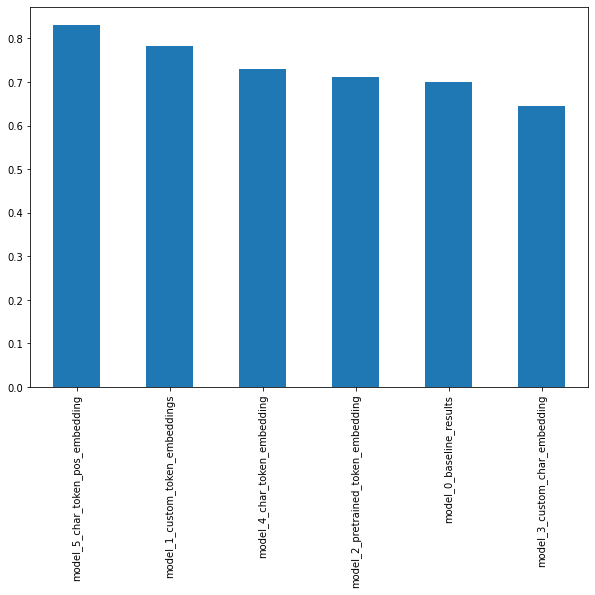

In [ ]:
# Sort results by 'f1-score'
all_model_results = all_model_results.sort_values('f1', ascending=False)['f1'].plot(kind='bar', figsize=(10,7))

# Saving and loading a model

We will save model_5, our best performing model

In [ ]:
# Saving a model
model_5.save('SkimLit_model')

INFO:tensorflow:Assets written to: SkimLit_model/assets


INFO:tensorflow:Assets written to: SkimLit_model/assets


In [ ]:
# Load in the model
loaded_model = tf.keras.models.load_model('/content/SkimLit_model')

In [ ]:
model_5_results

{'accuracy': 83.27154772937905,
 'f1': 0.8316198137680574,
 'precision': 0.8312978692929838,
 'recall': 0.8327154772937906}

The loaded model should give the same results

In [ ]:
loaded_model_pred_probs = loaded_model.predict(val_char_token_pos_dataset)
loaded_model_preds = tf.argmax(loaded_model_pred_probs, axis=1)
loaded_model_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [ ]:
# Calculate results
loaded_model_results = calculate_results(val_labels_encoded,
                                         loaded_model_preds)
loaded_model_results

{'accuracy': 83.27154772937905,
 'f1': 0.8316198137680574,
 'precision': 0.8312978692929838,
 'recall': 0.8327154772937906}

In [ ]:
model_5_results == loaded_model_results

True

In [ ]:
# Check loaded_model summary
loaded_model.summary()

Model: "model_5_token_char_positional_embedding"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_inputs (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_inputs[0][0]                
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_inputs[0][0]               
____________________________________________________________